In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import time
import os
import numpy as np
import pickle

In [2]:
SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"
#SATELLITE_ZARR_PATH = 'eumetsat_seviri_hrv_uk.zarr'

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

In [3]:
x_range = (550, 950)
y_range = (375, 700)

Filter latitude and longitude

In [4]:
selection = dataset.isel(x=slice(*x_range), y=slice(*y_range))

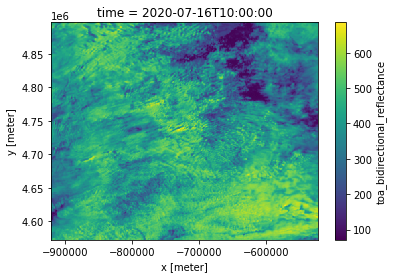

In [5]:
selection['data'].sel(time='2020-07-16 10:00:00').plot()
plt.show()

Get valid times only filter

In [6]:
def get_daylight_time(time_val):
    curr_time = time_val.time()
    start_time = time(hour=8, minute=0) # 8:00
    end_time = time(hour=17, minute=0) # 17:00 (5 PM)
    return curr_time >= start_time and curr_time <= end_time

Dataset creation

In [7]:
dir_loc = 'uk_data_np'
data_loc = os.path.join(dir_loc, 'data')
time_2_idx_path = os.path.join(dir_loc, 'time_2_idx')
idx_2_time_path = os.path.join(dir_loc, 'idx_2_time')

In [8]:
if not os.path.isdir(dir_loc):
    os.mkdir(dir_loc)
if not os.path.isdir(data_loc):
    os.mkdir(data_loc)

In [13]:
valid_times = list(filter(get_daylight_time, dataset.get_index('time')))
time_2_idx = {}
idx_2_time = []

arrays_in_stack = 20

#time to index conversions
idx_2_time = list(valid_times)
times_2_idx = dict({t : i for i, t in enumerate(idx_2_time)})
with open(time_2_idx_path, 'wb') as t2i_f:
    pickle.dump(time_2_idx, t2i_f)
t2i_f.close()
with open(idx_2_time_path, 'wb') as i2t_f:
    pickle.dump(idx_2_time, i2t_f)
i2t_f.close()

s_no = arrays_in_stack-1
end_time_i = arrays_in_stack-1
start_time_i = 0
while valid_times[end_time_i] <= valid_times[-1]:
    sample_np = dataset['data'].sel(time=valid_times[start_time_i:end_time_i+1]).to_numpy()
    
    file_name = str(s_no) + '.npz'
    file_path = os.path.join(data_loc, file_name)
    np.savez_compressed(file_path, data=sample_np)

    s_no += arrays_in_stack
    start_time_i += arrays_in_stack
    end_time_i += arrays_in_stack
    if end_time_i >= len(valid_times):
        end_time_i = len(valid_times)-1

    # if s_no == 20:
    #     break

KeyboardInterrupt: 

Test our save

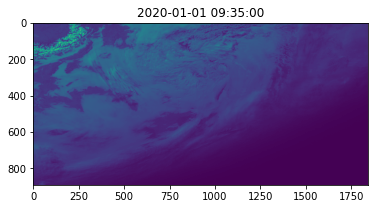

In [12]:
idx = 19
np_val = np.load(f'uk_data_np/data/{idx}.npz')
i2t = ()
with open(f'uk_data_np/idx_2_time', 'rb') as i2t_f:
    i2t = pickle.load(i2t_f)
i2t_f.close()
curr_time = i2t[idx]
plt.imshow(np_val['data'][idx], cmap='viridis')
plt.title(str(curr_time))
plt.show()